## 필요한 모듈들 임포트

## Fine tuning
사전 훈련된 모델을 기반으로 아키텍쳐를 새로운 목적에 맞게 변형하고 이미 학습된 모델의 가중치를 미세하게 조정해 학습시키는 방법
    - 사전 훈련된 모델의 가중치를 초기값으로 사용하고 추가로 학습
    - CNN 베이스의 사전학습 모델을 사용할 때에는 이전에 학습한 내용들을 모두 잊어버릴 위험이 있기 때문에 작은 learning rate를 사용하는것이 바람직함
[방법1] 모델 전체를 새로 학습
- 사전 학습 모델의 구조만 사용하면서, 자신의 데이터셋에 맞게 모델을 전부 새롭게 학습시키는 방법
- 데이터의 크기가 크고 유사성이 작을 때 사용
[방법2] Conv base는 일부분 고정(Freezing)하고 나머지 Conv Base 계층과 Classifier를 새롭게 학습
- Conv base: 합성곱 층과 풀링 층이 여러 겹 쌓여있는 부분으로 특징을 추출하는 역할
- Classifier: 주로 완전연결계층으로 구성되며 Conv base가 추출한 특징들을 잘 학습해 각각의 샘플들을 알맞은 class로 분류
- 낮은 레벨의 계층은 일반적이고 독리적인 특징(신형성)을 추출하고, 높은 레벨의 계층은 구체적이고 명확한 특징(형상)을 추출
- 크기가  크고 유사성도 높은 데이터셋일 때
[방법3] Conv Base는 고정하고 Classifier만 새로 학습
- 컴퓨팅 연산 능력이 부족하거나, 데이터셋이 너무 작을 때, 혹은 적용하려는 task와 사전학습에 쓰인 데이터가 매우 비슷할 때 사용

[크기가 작고 유사성도 작은 데이터]
- 방법2를 쓰되 조금 더 깊은 계층까지 새로 학습시키
- Data Augmentation 하기

[Feature Extraction]
사전 훈련된 모델의 하위 층을 동결하고, 상위 층을 새로운 작업을 위해 수정하지 않고 사용하는 것 -> 데이터분류기(마지막 완전연결층) 부분만 새로 만드는 것
    - 사전 훈련된 모델(고정): 중요한 특성 추출(학습 X)
    - 데이터분류기: 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류(학습O)
    - 가능한 모델: Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet

[ 분류기 수정하는 방법 ]
Fine tunning을 하기 전 input값으로 받는 이미지의 크기는 무조건 확인해야함
    - 대부분의 모델은 (224, 224)이지만 inception_v3의 경우 (299, 299)
1. print(model)로 마지막 층의 in_features 확인
2. nn.Linear(in_features, num_classes)로 클래스 수 변경
    - 예시1: Resnet
        - (fc): Linear(in_features=512, out_features=1000, bias=True)
            - => model.fc = nn.Linear(512, num_classes)
    - 예시2: Alexnet
        - (classifier): Sequential(... (6): Linear(in_features=4096, out_features=1000, bias=True)
            - => model.classifier[6] = nn.Linear(4096, num_classes)
    - 예시3(특이구조): Squeezenet
        - - output은 classifier의 첫번째 레이어인 1X1 convolution layer로부터 나옴
        - (classifier): Sequential((0): Dropout(p=0.5)  (1): Conv2d(512, 1000, kernel_size=13, stride=1, padding=0)  (2): ReLU(inplace)  (3): AvgPool2d(kernel_size=13, stride=1, padding=0))
            -  => model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    - 예시4(특이구조): Inception v3
        - Rethinking을 하기 때문에 학습과정에서 output이 두개의 레이어로부터 나옴
        - 두번째 output(auxiliary output): AuxLogits 부분을 포함하는 네트워크에 포함됨
        - 주된 output은 네트워크의 마지막 레이어에서 출력됨
            -  test 시에는 이 output만 고려함
        - (AuxLogits): InceptionAux(... (fc): Linear(in_feature=768, out_features=1000, bias=True) ... (fc): Linear(in_features=2048, out_features=1000, bias=True)
            -  finetune 하기 위해서는 두 레이어를 reshape 해줘야함
            -  => model.AuxLogits.fc = nn.Linear(768, num_classes)
            -  model.fc = nn.Linear(2048, nuum_classes)

[ 사용가능한 함수들 ]
- get_model(name, **config): 모델 이름과 환경설정을 인수로 받아 해당 모델의 인스턴스를 반환
    - get_model("quantized_mobilenet_v3_large", weights="DEFAULT")
- get_model_weight(name): 해당 모델의 열거형 가중치 클래스 반환
    - 예1: get_model_weights("quantized_mobilenet_v3_large")
    - 예2: get_model_weights(torchvision.models.quantization.mobilenet_v3_large)
    - 예1 = 예2
- get_weight(name): 열거형 가중치 변수의 이름으로 값을 가져옴
    - 예: get_weight("MobileNet_V3_Large_QuantizedWeights.DEFAULT")
- list_models(\[module]): 해당 이름으로 등록된 모델 목록을 반환


In [1]:
import copy
import time

import pandas
from tqdm.notebook import tqdm as tqdm_notebook
import cv2
import matplotlib.pyplot as plt
import numpy as np
from thop import profile
import pickle
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

from custom_models import CustomMobileNetV3Large, QuantizedCustomMobileNetV3Large, CustomMnasNet1_3, QuantizedCustomMnasNet1_3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception', 'mobilenet']

## Helper Functions

#### 모델 파라미터의 requires_grad 속성
- 기본적으로 사전  훈련된 모델을 로드할 때 모든 매개변수의 requires_grad = True로 설정되어 있음
    - True: 처음부터 훈련하거나 fine tuning할 때는 True
    - False(Freeze): 기존 layer의 weight를 고정

In [2]:
# 모델학습 헬퍼 함수
def train_models(model, dataloaders, criterion, optimizer, num_epochs=5, is_inception=False, quantize=False):
    torch.cuda.empty_cache()
    since = time.time()

    val_acc_history = []
    val_top5_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 3
    no_improvement_count = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-' * 10)

        # 각 에폭은 학습/검증 phase를 가짐
        for phase in ['train', 'val']:
            print(f'>>>>> phase: {phase}<<<<<')
            if phase == 'train':
                model.train()  # 트레이닝 모드 설정
            else:
                if quantize == True:
                    # 모델을 양자화 + 추론모드
                    model = torch.quantization.convert(model.eval(), inplace=False)
                else:
                    model.eval()  # 추론 모드 설정

            running_loss = 0.0
            running_corrects = 0
            running_top5_corrects = 0

            # 데이터 학습하기
            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 파라미터 기울기 초기화
                optimizer.zero_grad()

                # forward
                # 학습 모드인 경우에만 history 추적
                with torch.set_grad_enabled(phase == 'train'):
                    # 모델의 ouptut과 loss를 구함
                    # inception의 경우 학습시 auxiliary output이 있는 특수 케이스임.
                    #   학습시: final output과 auxiliary output을 더하는 과정이 필요함
                    #   테스트시: final output만 고려
                    # Auxilary output을 같이 고려해야하는 학습단계
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # top-5 정확도 계산
                    _,top5_preds = torch.topk(outputs, 5)
                    top5_corrects = torch.sum(top5_preds == labels.view(-1, 1))

                    # 학습(backward + optimize)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (epoch + 1) % 5 == 0:
                            # 모델 및 다른 정보 저장
                            save_path = f'save/{type(model).__name__}_epoch{epoch+1}_batchsize{batch_size}_quntize({quantize}).pth'
                            torch.save({
                                'model_state_dict': model.state_dict(),  # 모델 가중치 저장
                                'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태 저장 (선택적)
                                'epoch': epoch+1,  # 현재 학습 에폭 저장 (선택적)
                                # 다른 필요한 정보 저장 (선택적)
                            }, save_path)

                # loss 구하기
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_top5_corrects += top5_corrects

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_top5_acc = running_top5_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 모델 깊은복사
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_count = 0  # 개선이 있었으므로 카운트 초기화
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_top5_acc_history.append(epoch_top5_acc.item())
                no_improvement_count += 1  # 개선이 없었으므로 카운트

            # Early Stopping 확인
            # if no_improvement_count >= patience:
            #     print(f"No improvement in validation accuracy for {patience} epochs. Early stopping...")
            #     break  # 학습 종료

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    print('Best top5 val Acc: {:.4f}'.format(epoch_top5_acc))

    # 베스트 모델 가중치를 로드
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_top5_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [3]:
def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True, quantize=False):
    # 모델마다 다르게 지정될 변수들 초기화
    model_ft = None
    input_size = 0

    if model_name == 'resnet':
        if quantize:
            '''Quantized Resnet50'''
            weights = models.quantization.ResNet50_QuantizedWeights.DEFAULT
            model_ft = models.quantization.resnet50(weights=weights, quantize=True)
        else:
            '''Resnet50'''
            model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == 'mobilenet':
        if quantize:
            '''Quantized Mobilenet v3 large'''
            model_ft = QuantizedCustomMobileNetV3Large(num_classes=500).to('cpu')

            # 양자화 설정 - gbgemm 백엔드 사용
            backend = 'fbgemm'
            # 양자화 스키마 설정 (예: symmetric)
            quantization_params = torch.quantization.get_default_qconfig(backend)
            quantization_params = torch.quantization.QConfig(activation=quantization_params.activation, weight=quantization_params.weight)

            # 양자화 준비
            model_ft.qconfig = quantization_params
            model_ft= torch.quantization.prepare_qat(model_ft, inplace=False)

        else:
            model_ft = CustomMobileNetV3Large(num_classes=500).to(device)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == 'mnasnet':
        if quantize:
            '''Quantized Mnasnet 1_3'''
            model_ft = QuantizedCustomMnasNet1_3(num_classes=500).to(device)

            # 양자화 설정 - gbgemm 백엔드 사용
            backend = 'fbgemm'
            model_ft.qconfig = torch.quantization.get_default_qat_qconfig(backend)

            # 양자화 준비
            model_ft= torch.quantization.prepare_qat(model_ft, inplace=False)

        else:
            model_ft = models.mnasnet1_3(weights=models.MNASNet1_3_Weights.IMAGENET1K_V1)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
            # model_ft = CustomMnasNet1_3(num_classes=500).to(device)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == 'efficientnet':
        if quantize:
            pass
        else:
            model_ft = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == 'shufflenet':
        if quantize:
            pass
        else:
            model_ft = models.shufflenet_v2_x2_0(weights=models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, num_classes, bias=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == 'alexnet':
        '''AlexNet'''
        model_ft = models.alexnet(pretrianed=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_featrues
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'vgg':
        '''VGG11_bn'''
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'squeezenet':
        '''Squeezenet 1.0'''
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == 'densenet':
        '''Densenet 121'''
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'inception':
        '''Inception V3'''
        if quantize:
            weights = models.quantization.Inception_V3_QuantizedWeights.DEFAULT
            model_ft = models.quantization.inception_v3(weights=weights, quantize=True)
        else:
            model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299  # 다른 모델과 다르게 299 사이즈를 사용
    else:
        print('모델의 이름을 잘못 입력하여 종료합니다...')
        exit()

    return model_ft.to(device), input_size

## 데이터셋 생성1 - 증강없음

In [ ]:
# 데이터 경로
data_root = f'D:/data/training/sources/cropped'

# 데이터 변환
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder로 전체 데이터셋 생성
dataset = datasets.ImageFolder(root=data_root, transform=data_transforms)

# # 클래스 별 샘플 수 확인
# class_counts = torch.bincount(torch.tensor(dataset.targets))
# print('클래스별 샘플 수:', class_counts.unique())

# 데이터셋 분할 (예: 80% 훈련, 20% 검증)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터 로더 생성
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_dataloader, 'val': valid_dataloader}

print('train > ', len(train_dataloader), 'val > ', len(valid_dataloader))

## 데이터셋 셍성2 - 증강

In [5]:
import os
from shutil import copyfile
from torchvision import datasets

# 원본 데이터 폴더 경로
data_root = 'D:/data/training/sources/cropped'  # 데이터 경로를 본인의 환경에 맞게 수정

# 분할된 데이터를 저장할 폴더 경로
train_root = 'D:/data/training/sources/train'
valid_root = 'D:/data/training/sources/valid'

# 클래스 이름을 가져오기 위한 함수
def get_class_names(data_root):
    class_names = os.listdir(data_root)
    return class_names

# 클래스 이름 목록 가져오기
class_names = get_class_names(data_root)

# 클래스별로 train과 valid 폴더 생성
for class_name in class_names:
    train_class_dir = os.path.join(train_root, class_name)
    valid_class_dir = os.path.join(valid_root, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)

# 데이터를 8:2 비율로 나누어 train과 valid 폴더에 복사
for class_name in tqdm_notebook(class_names):
    class_dir = os.path.join(data_root, class_name)
    train_class_dir = os.path.join(train_root, class_name)
    valid_class_dir = os.path.join(valid_root, class_name)

    # 클래스 폴더 안의 모든 파일 목록 가져오기
    files = os.listdir(class_dir)
    num_files = len(files)
    num_train_files = int(0.8 * num_files)

    # 파일을 train과 valid 폴더에 복사
    for i, file in enumerate(files):
        src_path = os.path.join(class_dir, file)
        if i < num_train_files:
            dst_path = os.path.join(train_class_dir, file)
        else:
            dst_path = os.path.join(valid_class_dir, file)
        copyfile(src_path, dst_path)

  0%|          | 0/500 [00:00<?, ?it/s]

train >  999 val >  253
Epoch 1 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.9941 Acc: 0.7582
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 1.5053 Acc: 0.5899

Epoch 2 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.2200 Acc: 0.9279
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 1.7265 Acc: 0.5643

Epoch 3 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.1674 Acc: 0.9424
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 1.4373 Acc: 0.6278

Epoch 4 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.1383 Acc: 0.9521
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.5136 Acc: 0.8424

Epoch 5 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.1219 Acc: 0.9579
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 1.8802 Acc: 0.6029

Epoch 6 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.1115 Acc: 0.9613
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.3564 Acc: 0.8838

Epoch 7 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.1017 Acc: 0.9644
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.5792 Acc: 0.8241

Epoch 8 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.0932 Acc: 0.9679
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.6286 Acc: 0.8108

Epoch 9 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.0895 Acc: 0.9686
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.4922 Acc: 0.8453

Epoch 10 / 10
----------
>>>>> phase: train<<<<<


  0%|          | 0/999 [00:00<?, ?it/s]

train Loss: 0.0822 Acc: 0.9711
>>>>> phase: val<<<<<


  0%|          | 0/253 [00:00<?, ?it/s]

val Loss: 0.3139 Acc: 0.9020

Training complete in 376m 34s
Best val Acc: 0.9020
Best top5 val Acc: 0.9897


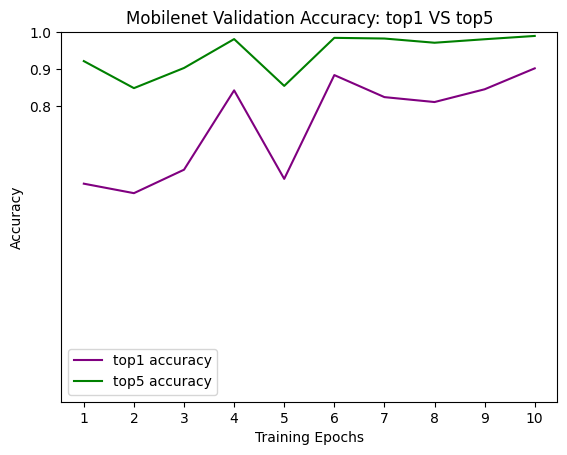

In [6]:
# 데이터 변환: 데이터가 부족해 과적합이 발생한 것으로 보이므로 학습데이터 증강
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(19, 19), sigma=(1.0, 2.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=0.1, p=0.5),
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-30, 30)),  # 무작위 회전 (-30도에서 30도 사이)
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), shear=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder를 사용하여 train과 valid 데이터셋 생성
train_dataset = datasets.ImageFolder(root=train_root, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_root, transform=valid_transforms)

# 데이터 로더 생성
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

dataloaders_dict = {'train': train_dataloader, 'val': valid_dataloader}

print('train > ', len(train_dataloader), 'val > ', len(valid_dataloader))

# 학습

mobilenet, input_size = initialize_model(model_name='mobilenet', num_classes=500, use_pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(mobilenet.parameters(), lr=0.0004)

mobilenet, val_acc_history, val_top5_acc_history = train_models(mobilenet, dataloaders_dict, criterion, optimizer, num_epochs=10, is_inception=False, quantize=False)

accuracy_mobilenet = {
    'top1': val_acc_history,
    'top5': val_top5_acc_history}
with open('save/accuracies_mobilenet_augmentated.json', 'w') as f:
    json.dump(accuracy_mobilenet, f)

save_path = f'save/mobilenet_epoch10_batch128_pretrained_Augmentated.pth'
torch.save({
    'model_state_dict': mobilenet.state_dict(),  # 모델 가중치 저장
    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태 저장 (선택적)
    'epoch': 10,  # 현재 학습 에폭 저장 (선택적) # 다른 필요한 정보 저장 (선택적)
}, save_path)

num_epochs = 10
plt.title("Mobilenet Validation Accuracy: top1 VS top5")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),val_acc_history,label="top1 accuracy", color='purple')
plt.plot(range(1,num_epochs+1),val_top5_acc_history,label="top5 accuracy", color='green')

plt.ylim((0,1.))
plt.yticks([0.8, 0.9, 1.0])
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 데이터셋 생성3 - 흑백 + 가중치조절

In [7]:
from torchvision.transforms import Grayscale
# 데이터 경로
data_root = f'D:/data/training/sources/cropped'

# 데이터 변환: 이미지 데이:?"터를 흑백데이터로 변환해 학습하기
data_transforms = transforms.Compose([
    Grayscale(num_output_channels=1),  # 흑백 변환 (1 채널)
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])  # 흑백 이미지의 경우 평균과 표준편차는 하나의 값만 사용
])

# ImageFolder로 전체 데이터셋 생성
dataset = datasets.ImageFolder(root=data_root, transform=data_transforms)

# 데이터셋 분할 (예: 80% 훈련, 20% 검증)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])



# 클래스별 샘플 수 계산
class_counts = torch.bincount(torch.tensor(train_dataset.dataset.targets))
print('클래스별 샘플 수:', class_counts)

# 클래스별 데이터 샘플 수를 기반으로 WeightedRandomSampler를 사용하여 샘플링
# 클래스 가중치: 클래스별 역수로 계산 => 샘플 수가 적을수록 가중치가 높아짐
class_weights = 1.0 / class_counts.double()
# 클래스 가중치 적용
sample_weights = class_weights[train_dataset.dataset.targets]
# WeightedRandomSampler를 이용해 데이터 샘플링
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 데이터 로더 생성
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_dataloader, 'val': valid_dataloader}

print('train > ', len(train_dataloader), 'val > ', len(valid_dataloader))
# # 리스트를 텍스트 파일로 저장하기
# with open(f'save/classes_batch{batch_size}.pkl', 'wb') as f:
#     pickle.dump(dataset.classes, f)

클래스별 샘플 수: tensor([1296,  216,  216,  216,  216,  216,  216,  216,  324,  324,  216,  216,
         216,  324,  216,  216,  216,  216,  216,  216,  216,  216,  216,  324,
         324,  324,  216,  216,  324,  324,  324,  216,  216,  216,  324,  216,
         324,  324,  216,  216,  216,  216,  216,  216,  324,  216,  216,  324,
        1296,  216,  216,  324,  216,  324,  324,  216,  216,  216,  324,  216,
         216, 1296, 1296,  216,  324,  216,  216,  216,  216,  216,  324,  216,
         324,  216,  216,  324,  216,  216, 1296,  432,  216,  216,  324,  324,
         216,  216,  216,  216,  216,  216,  216,  216,  216,  324,  324,  324,
         216,  324,  216,  216,  216,  216,  216,  324, 1296,  216,  324,  216,
         216,  216,  324,  324,  324,  216,  324,  324,  324,  324,  324,  324,
         324,  216,  216,  216,  216,  324,  216,  216,  324,  216,  216,  324,
         216,  216,  216,  216,  216,  216,  324,  216,  324,  216,  216,  216,
         216,  216,  216,  21

In [ ]:
# train_classes = set()
# for data in tqdm_notebook(train_dataset):
#     _, label = data  # 데이터와 레이블을 분리
#     train_classes.add(label)  # 레이블을 set에 추가하여 중복 클래스 제거
#
# num_train_classes = len(train_classes)
# print("훈련 데이터셋 클래스 수:", num_train_classes)
#
# valid_classes = set()
# for data in tqdm_notebook(valid_dataset):
#     _, label = data
#     valid_classes.add(label)
#
# num_valid_classes = len(valid_classes)
# print("검증 데이터셋 클래스 수:", num_valid_classes)
#
# test_classes = set()
# for data in tqdm_notebook(test_dataset):
#     _, label = data
#     test_classes.add(label)
#
# num_test_classes = len(test_classes)
# print("테스트 데이터셋 클래스 수:", num_test_classes)

In [ ]:
mobilenet, input_size = initialize_model(model_name='mobilenet', num_classes=500, use_pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(mobilenet.parameters(), lr=0.0004)

mobilenet, val_acc_history, val_top5_acc_history = train_models(mobilenet, dataloaders_dict, criterion, optimizer, num_epochs=10, is_inception=False, quantize=False)

save_path = f'save/mobilenet_epoch10_batch128_pretrained_noQuantize.pth'
torch.save({
    'model_state_dict': mobilenet.state_dict(),  # 모델 가중치 저장
    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태 저장 (선택적)
    'epoch': 10,  # 현재 학습 에폭 저장 (선택적) # 다른 필요한 정보 저장 (선택적)
}, save_path)

In [ ]:
def testing_models(models, dataloaders_dict, num_epochs, num_classes=1000, feature_extract=False, use_pretrained=True, quantize=False):
    acc = {}

    for model_name in models:
        torch.cuda.empty_cache()

        model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained, quantize=quantize)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.NAdam(model.parameters(), lr=0.001)

        print('device > ', device)
        print(f'{model_name} / pretrained({use_pretrained}) / quantize({quantize})')

        model, hist, top5_hist = train_models(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=False, quantize=quantize)

        acc[model_name] = {
            'top1': hist,
            'top5': top5_hist
        }

    return accuracies

In [ ]:
model_name = 'mobilenet'
num_epochs = 2
quantize = False
model, hist, top5_hist = train_models(model_name, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=False, quantize=quantize)

In [ ]:
# models = ['mobilenet', 'mnasnet', 'efficientnet', 'shufflenet']
accuracies_quantized = testing_models(models=['mobilenet'], dataloaders_dict=dataloaders_dict, num_epochs=5, num_classes=500, feature_extract=False, use_pretrained=True, quantize=True)

In [ ]:
accuracies= testing_models(models=['mobilenet'], dataloaders_dict=dataloaders_dict, num_epochs=5, num_classes=500, feature_extract=False, use_pretrained=True, quantize=False)
print(accuracies)

In [ ]:
import json

with open('save/accuracies.json', 'w') as f:
    json.dump(accuracies, f)

In [ ]:
save_path = f'save/mobilenet_epoch10.pth'
torch.save({
    'model_state_dict': mobilenet.state_dict(),  # 모델 가중치 저장
    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태 저장 (선택적)
    'epoch': 10,  # 현재 학습 에폭 저장 (선택적) # 다른 필요한 정보 저장 (선택적)
}, save_path)

In [ ]:
accuracies['mnasnet']['top5']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 5
plt.title("Top1 Validation Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),losses['mobilenet']['top1'],label="mobilenet", color='purple')
plt.plot(range(1,num_epochs+1),losses['mnasnet']['top1'],label="mnasnet", color='red')
plt.plot(range(1,num_epochs+1),losses['efficientnet']['top1'],label="efficientnet", color='yellow')
plt.plot(range(1,num_epochs+1),losses['shufflenet']['top1'],label="shufflenet", color='green')
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
num_epochs = 5
plt.title("Top5 Validation Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),losses['mobilenet']['top5'],label="mobilenet", color='purple')
plt.plot(range(1,num_epochs+1),losses['mnasnet']['top5'],label="mnasnet", color='red')
plt.plot(range(1,num_epochs+1),losses['efficientnet']['top5'],label="efficientnet", color='yellow')
plt.plot(range(1,num_epochs+1),losses['shufflenet']['top5'],label="shufflenet", color='green')
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
num_epochs = 10
plt.title("Mobilenet Validation Accuracy: top1 VS top5")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),val_acc_history,label="top1 accuracy", color='purple')
plt.plot(range(1,num_epochs+1),val_top5_acc_history,label="top5 accuracy", color='green')

plt.ylim((0,1.))
plt.yticks([0.8, 0.9, 1.0])
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## 이미지 추론

In [ ]:
# 모델 불러올 경로 설정
# load_path = f'save/{model_name}_epoch{num_epochs}_quntize({quantize}.pth)'
from PIL import Image

# 이미지 추론 코드
def infer(image_path, image_label):
    since = time.time()
    image = Image.open(image_path)
    label = image_label
    desired_size = (224, 224)
    image = image.resize(desired_size)

    # 모델 및 다른 정보 불러오기
    load_path = 'save/mobilenet_epoch10_batch128_pretrained_noQuantize.pth'
    checkpoint = torch.load(load_path)
    model = CustomMobileNetV3Large(num_classes=500)
    model.load_state_dict(checkpoint['model_state_dict'])  # 모델 가중치 불러오기
    print(f'Model loaded from {load_path}')

    model.to(device)
    model.eval()

    # 사진을 모델 입력에 맞게 resize
    preprocess  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0)
    print('input tensor 사이즈 > ', input_tensor.size())
    print(device)

    with torch.no_grad():
        outputs = model(input_tensor.to(device))

    _, predicted_index = torch.max(outputs, 1)
    predicted_index = predicted_index.item()

    # 클래스 이름
    with open('save/classes_batch128.pkl', 'rb') as pickle_file:
        classes = pickle.load(pickle_file)
        predicted_class = classes[predicted_index]

    end_time = time.time()

    # 모델이 예측한 클래스 인덱스 출력
    print('='*20)
    print('예측된 클래스 인덱스: ', predicted_index)
    print('클래스 이름: ', predicted_class)
    print('일치여부(클래스): ', predicted_class==label)
    # print('일치여부(타겟): ', predicted_index==label)
    print('추론 시간: ', end_time-since)
    print('='*20)

    return predicted_class, predicted_class==label

# sample1: uncropped
image1_path = 'save/K-039306(cropped).jpg'
image1_label = 'K-039306'
image1_predictiton, image1_correct = infer(image1_path, image1_label)

# sample2: cropped
image2_path = 'save/K-039306(uncropped).jpg'
image2_label = 'K-039306'
image2_predictiton, image2_correct = infer(image2_path, image2_label)

## 모델들의 GFLOPS & Parameters 비교

In [ ]:
input_size = (batch_size, 3, 224, 224)  # (배치 크기, 채널 수, 높이, 너비)

# 모델 불러와 적용하기

# model_names = ['mobilenet', 'mobilenet(quantized)', 'efficientnet', 'shufflenet']
model_names = ['mobilenet', 'efficientnet', 'shufflenet']
gflops_list = []
params_list = []
# mobilenet
mobilenet = CustomMobileNetV3Large(num_classes=500)
checkpoint = torch.load('save/CustomMobileNetV3Large_epoch5_quntize(False).pth')
mobilenet.load_state_dict(checkpoint['model_state_dict'])  # 모델 가중치 불러오기
optimizer = torch.optim.NAdam(mobilenet.parameters(), lr=0.001)
mobilenet.eval()
# 모델의 FLOPs 계산
macs, params = profile(mobilenet, inputs=(torch.randn(*input_size),))
gflops_list.append(round(macs / 1e9, 3))
params_list.append(int(params/1000000))

# mobilenet(quantized)
# mobilenet_quantized = QuantizedCustomMobileNetV3Large(num_classes=500)
# checkpoint = torch.load('save/CustomMobileNetV3Large_epoch5_quntize(False).pth')
# mobilenet.load_state_dict(checkpoint['model_state_dict'])  # 모델 가중치 불러오기
# optimizer = torch.optim.NAdam(mobilenet_quantized.parameters(), lr=0.001)
# mobilenet.eval()
# macs, params = profile(mobilenet_quantized, inputs=(torch.randn(*input_size),))
# gflops_list.append(round(macs / 1e9, 3))
# params_list.append(int(params/1000000))

# 모델 불러와 적용하기
efficientnet = models.efficientnet_b0(num_classes=500)
checkpoint = torch.load('save/EfficientNet_epoch5_quntize(False).pth')
efficientnet.load_state_dict(checkpoint['model_state_dict'])  # 모델 가중치 불러오기
optimizer = torch.optim.NAdam(efficientnet.parameters(), lr=0.001)
efficientnet.eval()
macs, params = profile(efficientnet, inputs=(torch.randn(*input_size),))
gflops_list.append(round(macs / 1e9, 3))
params_list.append(int(params/1000000))

# shufflenet
shufflenet = models.shufflenet_v2_x2_0(num_classes=500)
checkpoint = torch.load('save/ShuffleNetV2_epoch5_quntize(False).pth')
shufflenet.load_state_dict(checkpoint['model_state_dict'])  # 모델 가중치 불러오기
optimizer = torch.optim.NAdam(shufflenet.parameters(), lr=0.001)
shufflenet.eval()
macs, params = profile(shufflenet, inputs=(torch.randn(*input_size),))
gflops_list.append(round(macs / 1e9, 3))
params_list.append(int(params/1000000))

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Comparison of GFLOPs in Different Models')
plt.xlabel('GFLOPs')
plt.legend(loc='best')
plt.bar(model_names, gflops_list, alpha=0.7, width=0.4, label='GFLOPs', color='b')

plt.subplot(1, 2, 2)
plt.title('Comparison of number of Parameters(M) in Different Models')
plt.xlabel('Parameters(M)')
plt.legend(loc='best')
plt.bar(model_names, params_list, alpha=0.7, width=0.4, label='Parameters(M)', color='g')
plt.tight_layout()
plt.show()

## 테스트

In [ ]:
def get_model():
  model = CustomMobileNetV3Large(num_classes=500)
  checkpoint = torch.load('save/CustomMobileNetV3Large_epoch5_quntize(False).pth')
  model.load_state_dict(checkpoint['model_state_dict'])

  return model

def test(test_dataloader):
    model = get_model().eval()
    correct = 0
    top5_correct = 0
    total = 0
    predict_list = []
    # 그라디언트 계산 비활성화 (테스트 모드)
    with torch.no_grad():
        for inputs, labels in tqdm_notebook(test_dataloader):
            outputs = model(inputs)
            _, top5 = torch.topk(outputs, k=5, dim=1)  # 상위 5개 예측을 가져옵니다.
            total += labels.size(0)
            # print(label, ' > ', predicted[:, 0] == labels)
            top1 = top5[:, 0]
            predict_list.append()
            correct += (top5[:, 0] == labels).sum().item()  # 상위 1개 예측이 정답과 일치하는 경우
            for i in range(5):
                top5_correct += (top5[:, i] == labels).sum().item()  # 상위 5개 예측 중 하나가 정답과 일치하는 경우

    accuracy = correct / total
    top5_accuracy = top5_correct / total

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")

    return accuracy, top5_accuracy, predict_list

accuracy, top5_accuracy, predict_list = test(test_dataloader)

## VIT 적용 및 학습

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import Dataset
import os

# 클래스 수
num_classes = 500

# 하이퍼파라미터
batch_size = 64
learning_rate = 1e-4
num_epochs = 5

# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []  # 이미지 파일 경로 리스트
        self.labels = []  # 레이블 리스트

        # 이미지 파일 경로와 레이블 로드
        # 예: 이미지 파일 경로가 data_dir/class_name/image.jpg 형식일 때
        for class_idx, class_name in enumerate(os.listdir(data_dir)):
            class_path = os.path.join(data_dir, class_name)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 전처리 및 DataLoader 설정
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(data_dir=f'D:/data/training/sources/cropped', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ViT 모델 로드
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
classifier = nn.Linear(model.config.hidden_size, num_classes)
model.classifier = classifier

# 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm_notebook(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

In [ ]:
save_path = f'save/vit_eph{num_epochs}.pth'
torch.save({
    'model_state_dict': mobilenet.state_dict(),  # 모델 가중치 저장
    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태 저장 (선택적)
    'epoch': num_epochs,  # 현재 학습 에폭 저장 (선택적) # 다른 필요한 정보 저장 (선택적)
}, save_path)

In [ ]:
# 추론
model.eval()

# 추론할 이미지 전처리
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = data_transform(image)
    image = image.unsqueeze(0)
    return image.to(device)

# 추론할 이미지 파일 경로
input_image_path = 'save/K-039306(cropped).jpg'

# 이미지 추론
with torch.no_grad():
    input_image = preprocess_image(input_image_path)
    outputs = model(input_image)
    _, predicted = torch.max(outputs.logits, 1)

# 예측 결과 출력
print(f"Predicted class: {predicted.item()}")